### Data exploration

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [29]:
raw_data = pd.read_csv('data/processed_cleveland_data.csv')
print(raw_data.info())
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
column_a    303 non-null int64
column_b    303 non-null bool
column_c    303 non-null int64
column_d    303 non-null int64
column_e    303 non-null int64
column_f    303 non-null bool
column_g    303 non-null int64
column_h    303 non-null int64
column_i    303 non-null bool
column_j    303 non-null float64
column_k    303 non-null int64
column_l    299 non-null float64
column_m    301 non-null float64
column_n    303 non-null int64
dtypes: bool(3), float64(3), int64(8)
memory usage: 27.0 KB
None


,column_a,column_b,column_c,column_d,column_e,column_f,column_g,column_h,column_i,column_j,column_k,column_l,column_m,column_n
0,63,True,1,145,233,True,2,150,False,2.3,3,0.0,6.0,0
1,67,True,4,160,286,False,2,108,True,1.5,2,3.0,3.0,2
2,67,True,4,120,229,False,2,129,True,2.6,2,2.0,7.0,1
3,37,True,3,130,250,False,0,187,False,3.5,3,0.0,3.0,0
4,41,False,2,130,204,False,2,172,False,1.4,1,0.0,3.0,0


Let's rename the columns to make further processing easier.

In [62]:
data = raw_data.rename(index=str, columns={"column_a": "age", "column_b": "sex", "column_c": "chest_pain",
                                          "column_d": "trestbps", "column_e": "cholesterol", "column_f": "fasting_bsugar",
                                          "column_g": "restecg", "column_h": "thalach", "column_i": "exercise_angina",
                                          "column_j": "oldpeak", "column_k": "slope", "column_l": "colored_vessels",
                                          "column_m": "thal", "column_n": "target"})

We can notice that there are 4 entries that have null values in column_l (attribute _ca_: number of major vessels (0-3) colored by flourosopy). There are another 2 entries with null values in column_m (attribute _thal_: heart rate defect). We could drop these instances from the `DataFrame`, but I'm not yet sure it is necessary.

In [63]:
data = data.dropna(subset=['thal'])
data = data.fillna(value=0, axis=0) # Fill colored_vessels na values with 0

Looking at the description of the data, we can see that both colored_vessels and thal are float. I think they would be more suitable as ints. The first represents the number of major vessels coloured by fluoroscopy, while the second is one of 3 numbers representing if the heart rate is normal (so it's a categorical attribute).

In [64]:
data['colored_vessels'] = data['colored_vessels'].astype('int')
data['thal'] = data['thal'].astype('int')

Let's check our changes and see some basic stats of the numeric columns:

In [65]:
print(data.info())
data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 301 entries, 0 to 302
Data columns (total 14 columns):
age                301 non-null int64
sex                301 non-null bool
chest_pain         301 non-null int64
trestbps           301 non-null int64
cholesterol        301 non-null int64
fasting_bsugar     301 non-null bool
restecg            301 non-null int64
thalach            301 non-null int64
exercise_angina    301 non-null bool
oldpeak            301 non-null float64
slope              301 non-null int64
colored_vessels    301 non-null int32
thal               301 non-null int32
target             301 non-null int64
dtypes: bool(3), float64(1), int32(2), int64(8)
memory usage: 26.7+ KB
None


,age,chest_pain,trestbps,cholesterol,restecg,thalach,oldpeak,slope,colored_vessels,thal,target
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000
mean,54.451827,3.156146,131.714286,246.936877,0.990033,149.700997,1.043189,1.601329,0.667774,4.734219,0.936877
std,9.067258,0.962048,17.655729,51.859869,0.994937,22.860817,1.163384,0.616872,0.935908,1.939706,1.229906
min,29.000000,1.000000,94.000000,126.000000,0.000000,71.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,3.000000,120.000000,211.000000,0.000000,134.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,3.000000,130.000000,242.000000,1.000000,153.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,4.000000,140.000000,275.000000,2.000000,166.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,4.000000,200.000000,564.000000,2.000000,202.000000,6.200000,3.000000,3.000000,7.000000,4.000000


Let's convert the target column to have just two values: we're interested in finding the presence of heart disease, rather than classifying the severity of the disease.

In [68]:
data.target = data.target.replace(to_replace=[2,3,4], value=1)

The next step is visualising the attributes to better understand them.

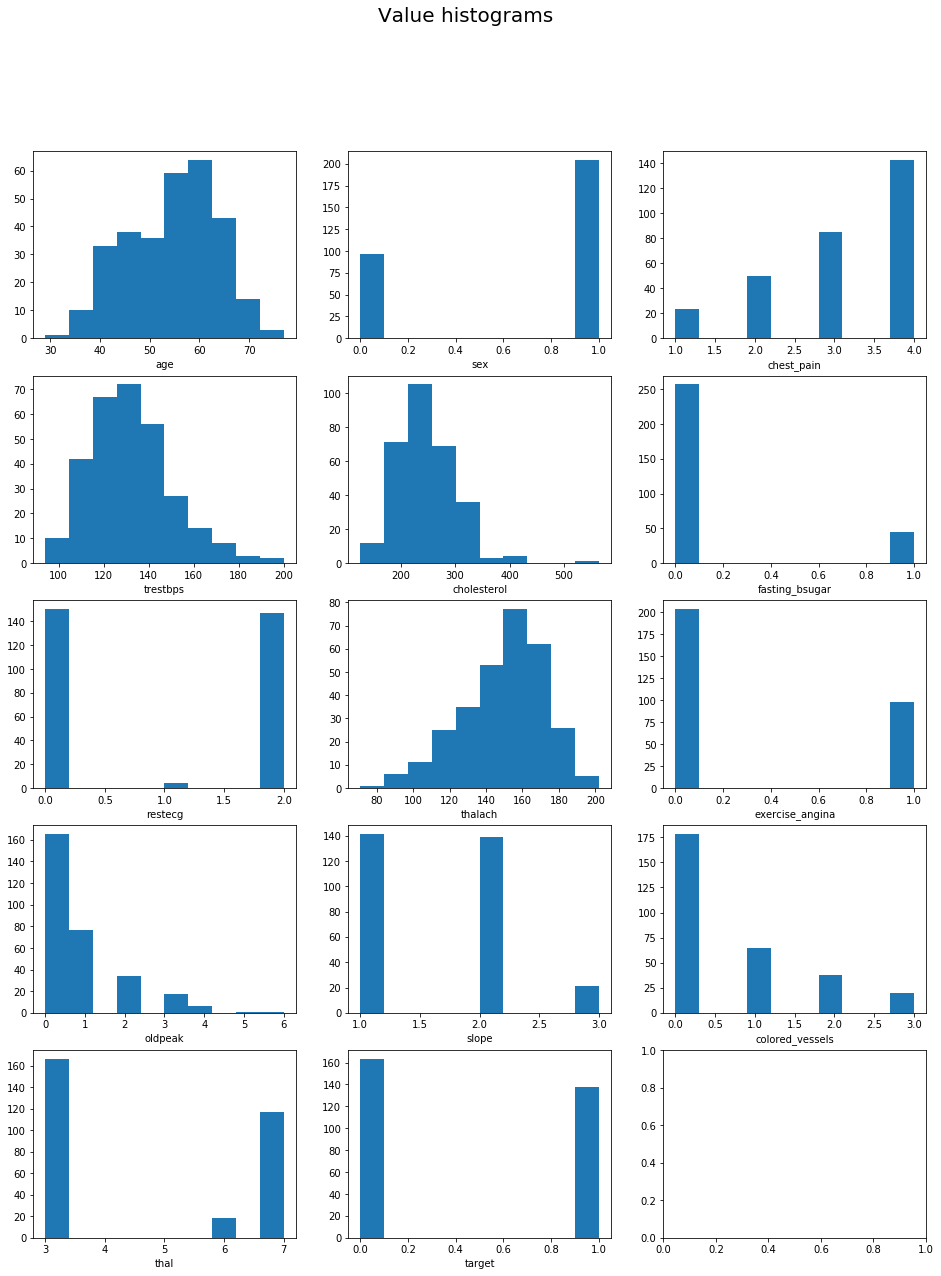

In [69]:
fig, ax = plt.subplots(ncols=3, nrows=5, figsize=(16,20))
fig.suptitle('Value histograms', fontsize=20)
ax = ax.flatten()

for i, col in enumerate(list(data)):
    ax[i].hist(x=data[col].astype(int))
    ax[i].set_xlabel(col) 

There are several categorical attributes: sex, fasting_bsugar, chest_pain, exercise_angina, restecg, colored_vessels, thal and slope. These have to be numerically encoded. We could consider one-hot encoding for attributes with more than 2 categories that do not have a natural ordering (such as chest_pain, slope, thal). 

### Prediction

In [101]:
x = data.loc[:, :'thal'].values
y = data.loc[:, 'target'].values
x_train, x_test, y_train, y_test = train_test_split(x, y)


def fit_and_print_performance(model):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    print('Accuracy on test: {0:.4f}'.format(accuracy), '\nMAE: {0:.4f}'.format(mae))

In [105]:
tree = DecisionTreeClassifier()
fit_and_print_performance(tree)

Accuracy on test: 0.7895 
MAE: 0.2105


Let's visualise the tree:

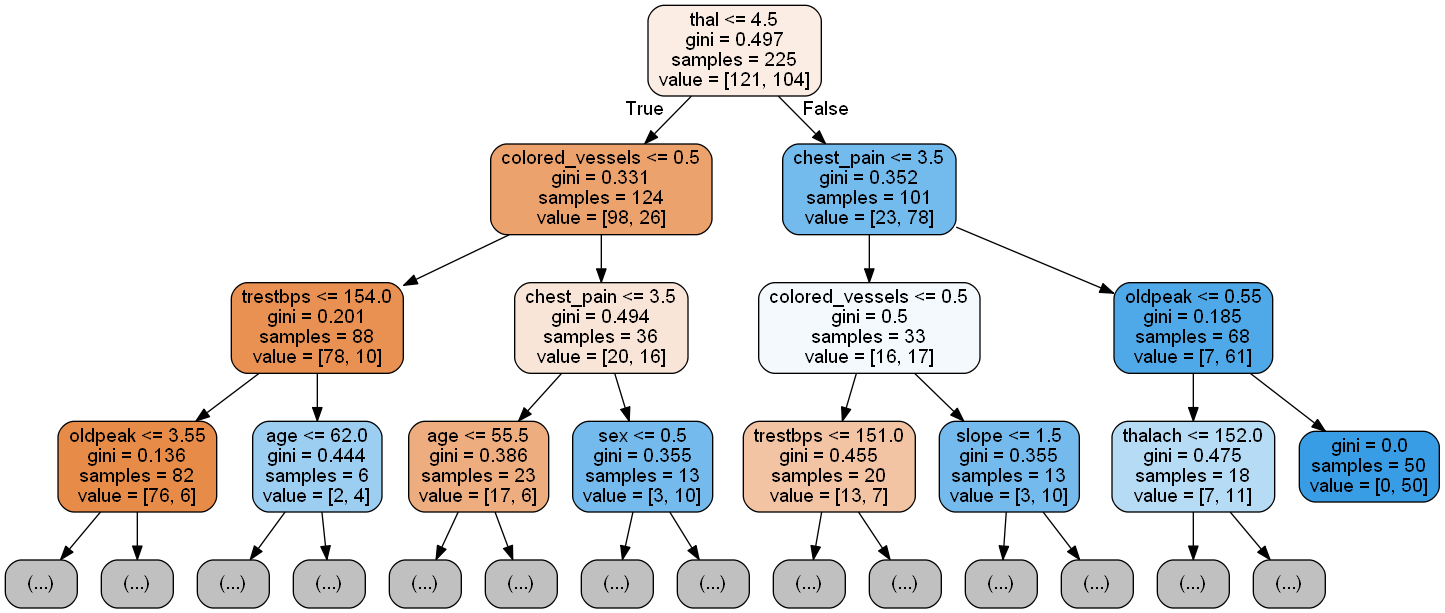

In [106]:
from sklearn.tree import export_graphviz
from IPython.display import Image, display


with open('tree.dot', 'w+') as dotfile:
    export_graphviz(tree, max_depth=3, out_file=dotfile, rounded=True, filled=True, feature_names=list(data)[:-1])

# Convert file to png
!dot -Tpng tree.dot -o tree.png
# Display in notebook
display(Image("tree.png"))

In [112]:
# Fit random forest
forest = RandomForestClassifier(n_estimators=50)
fit_and_print_performance(forest)

Accuracy on test: 0.8684 
MAE: 0.1316


In [111]:
# Fit extra trees
extra = ExtraTreesClassifier(n_estimators=50)
fit_and_print_performance(extra)

Accuracy on test: 0.8684 
MAE: 0.1316


In [116]:
fit_and_print_performance(LogisticRegression(solver='liblinear')) # regularisation is l2 by default

Accuracy on test: 0.9211 
MAE: 0.0789


In [120]:
fit_and_print_performance(GradientBoostingClassifier())

Accuracy on test: 0.8026 
MAE: 0.1974
